In [ ]:
!pip install deepface

     |████████████████████████████████| 63 kB 2.5 MB/s 
     |████████████████████████████████| 2.3 MB 71.5 MB/s 
     |████████████████████████████████| 462 kB 72.3 MB/s 


In [ ]:
!pip install filetype

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import os
import gdown
from zipfile import ZipFile
import pandas as pd
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import seaborn as sns
import torch
from natsort import natsorted
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
import cv2
import filetype



# Probando DeepFace

In [ ]:
from deepface import DeepFace

Directory  /root /.deepface created
Directory  /root /.deepface/weights created


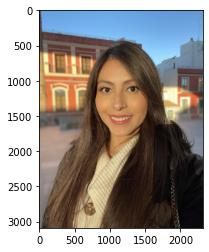

In [ ]:
img = mpimg.imread('/content/IMG_4806.JPG')
imgplot = plt.imshow(img)

In [ ]:
obj = DeepFace.analyze(img_path="/content/IMG_4806.JPG", actions = ['emotion'])

In [ ]:
obj

{'dominant_emotion': 'happy',
 'emotion': {'angry': 0.09100573952309787,
  'disgust': 0.003037696296814829,
  'fear': 0.7880255579948425,
  'happy': 93.30958127975464,
  'neutral': 5.352800711989403,
  'sad': 0.16152088064700365,
  'surprise': 0.29402729123830795},
 'region': {'h': 905, 'w': 905, 'x': 675, 'y': 791}}

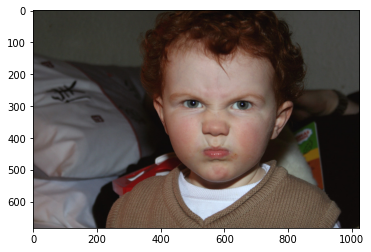

In [ ]:
img = mpimg.imread('/content/angry2.jpg')
imgplot = plt.imshow(img)

In [ ]:
obj = DeepFace.analyze(img_path="/content/angry2.jpg", actions = ['emotion'])

In [ ]:
obj

{'dominant_emotion': 'angry',
 'emotion': {'angry': 81.74595236778259,
  'disgust': 4.4232695017853985e-05,
  'fear': 0.8032121695578098,
  'happy': 0.0011053597518184688,
  'neutral': 0.6390499882400036,
  'sad': 16.808873414993286,
  'surprise': 0.001765026172506623},
 'region': {'h': 370, 'w': 370, 'x': 391, 'y': 152}}

# Cargar **celeb a dataset**

In [ ]:
dir = "celeba"

In [ ]:
try:
  os.makedirs(dir)
except Exception as e:
  pass

#url = "https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684"
url = 'https://drive.google.com/uc?id=1cNIac61PSA_LqDFYFUeyaQYekYPc75NH'
output = "celeba/data.zip"
gdown.download(url, output, quiet=True)

'celeba/data.zip'

In [ ]:
with ZipFile("celeba/data.zip", "r") as zipobj:
    zipobj.extractall(dir)

In [ ]:
zipobj.close()

In [ ]:
! ls

celeba	list_attr_celeba.txt  sample_data


In [ ]:
dir="."

# Cargar anotaciones

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dir="/content/drive/MyDrive/TFG/"

In [ ]:
def get_annotation(fnmtxt, verbose=True):
  if verbose:
      print("_" * 70)
      #print(dir +"/"+ fnmtxt)

  #rfile = open(dir+"/"+fnmtxt, 'r')
  rfile = open(fnmtxt, 'r')
  texts = rfile.read().split("\n")
  rfile.close()

  columns = np.array(texts[1].split(" "))
  columns = columns[columns != ""]
  df = []
  for txt in texts[2:]:
      txt = np.array(txt.split(" "))
      txt = txt[txt != ""]

      df.append(txt)

  df = pd.DataFrame(df)

  if df.shape[1] == len(columns) + 1:
      columns = ["image_id"] + list(columns)
  df.columns = columns
  df = df.dropna()
  if verbose:
      print(" Total number of annotations {}\n".format(df.shape))
      print(df.head())
  ## cast to integer
  for nm in df.columns:
      if nm != "image_id":
          df[nm] = pd.to_numeric(df[nm], downcast="float")
  return (df)

attr   = get_annotation(dir+"list_attr_celeba.txt")
align  = get_annotation(dir+"list_landmarks_align_celeba.txt")

#assert np.all(align["image_id"] == attr["image_id"])

______________________________________________________________________
 Total number of annotations (202599, 41)

     image_id 5_o_Clock_Shadow  ... Wearing_Necktie Young
0  000001.jpg               -1  ...              -1     1
1  000002.jpg               -1  ...              -1     1
2  000003.jpg               -1  ...              -1     1
3  000004.jpg               -1  ...              -1     1
4  000005.jpg               -1  ...              -1     1

[5 rows x 41 columns]
______________________________________________________________________
 Total number of annotations (202599, 11)

     image_id lefteye_x lefteye_y  ... leftmouth_y rightmouth_x rightmouth_y
0  000001.jpg        69       109  ...         152          108          154
1  000002.jpg        69       110  ...         151          108          153
2  000003.jpg        76       112  ...         156           98          158
3  000004.jpg        72       113  ...         155          101          151
4  000005.jpg   

In [ ]:
attr

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0
1,000002.jpg,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
2,000003.jpg,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
3,000004.jpg,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,-1.0,1.0
4,000005.jpg,-1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202594,202595.jpg,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0
202595,202596.jpg,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
202596,202597.jpg,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
202597,202598.jpg,-1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0


# Calcular expresión facial

In [ ]:
estimated_facial_expressions_2=[]

In [ ]:
dir_data = r"celeba/img_align_celeba/"
M = 55048
for i, myid in enumerate(align["image_id"][29710:M]):
    #print(i)
    image_dir = dir_data + "/" + myid

    obj = DeepFace.analyze(img_path=image_dir, actions = ['emotion'], enforce_detection=False,  prog_bar = False)
    estimated_facial_expressions_2.append((myid, obj['emotion']))
    #print(obj)
    #print(obj['age'])
    #print(align.loc[align['image_id'] == myid])
print("done.")

In [ ]:
len(estimated_facial_expressions_2), estimated_facial_expressions_2[0]

In [ ]:
#len(estimated_facial_expressions)

In [ ]:
np.savez_compressed('estimated_facial_expressions_2', estimated_facial_expressions_2)

In [ ]:

celeba_annotations_facial_exp = np.empty((0,2),int)
for i in range(1,3,1):
  celeba_annotations_facial_exp = np.append(celeba_annotations_facial_exp, np.load(f'{dir}estimated_facial_expressions_{i}.npz', allow_pickle=True)['arr_0'], axis=0)

In [ ]:
celeba_annotations_facial_exp

array([['000001.jpg',
        {'angry': 5.81176516044606e-14, 'disgust': 1.3143771696238857e-19, 'fear': 5.046025446445168e-11, 'happy': 99.99551773071289, 'sad': 4.904584984671834e-10, 'surprise': 1.8425981226921628e-09, 'neutral': 0.004487036494538188}],
       ['000002.jpg',
        {'angry': 5.18898124468592e-07, 'disgust': 1.319865598129617e-15, 'fear': 5.161797204944474e-10, 'happy': 97.66042828559875, 'sad': 7.136162327725515e-07, 'surprise': 1.3217341177096387e-05, 'neutral': 2.339562401175499}],
       ['000003.jpg',
        {'angry': 7.715348154306412, 'disgust': 0.009655892790760845, 'fear': 9.597587585449219, 'happy': 0.30413318891078234, 'sad': 36.09423339366913, 'surprise': 7.528483365604188e-05, 'neutral': 46.27896845340729}],
       ...,
       ['055046.jpg',
        {'angry': 2.8167844186086155, 'disgust': 0.00023988956723514516, 'fear': 5.3210449581092645, 'happy': 1.652617369280175, 'sad': 6.003656640212936, 'surprise': 0.06784107309425495, 'neutral': 84.137811167501

In [ ]:
celeba_annotations_facial_exp[:, 1:2].flatten()

array([{'angry': 5.81176516044606e-14, 'disgust': 1.3143771696238857e-19, 'fear': 5.046025446445168e-11, 'happy': 99.99551773071289, 'sad': 4.904584984671834e-10, 'surprise': 1.8425981226921628e-09, 'neutral': 0.004487036494538188},
       {'angry': 5.18898124468592e-07, 'disgust': 1.319865598129617e-15, 'fear': 5.161797204944474e-10, 'happy': 97.66042828559875, 'sad': 7.136162327725515e-07, 'surprise': 1.3217341177096387e-05, 'neutral': 2.339562401175499},
       {'angry': 7.715348154306412, 'disgust': 0.009655892790760845, 'fear': 9.597587585449219, 'happy': 0.30413318891078234, 'sad': 36.09423339366913, 'surprise': 7.528483365604188e-05, 'neutral': 46.27896845340729},
       ...,
       {'angry': 2.8167844186086155, 'disgust': 0.00023988956723514516, 'fear': 5.3210449581092645, 'happy': 1.652617369280175, 'sad': 6.003656640212936, 'surprise': 0.06784107309425495, 'neutral': 84.13781116750107},
       {'angry': 2.9685599915909777, 'disgust': 0.36104352100419745, 'fear': 30.2805566453

In [ ]:
facial_expressions = {}
for k,v in zip(celeba_annotations_facial_exp[:, 0:1].flatten(), celeba_annotations_facial_exp[:, 1:2].flatten()):
  facial_expressions[k]= max(v, key=v.get)

In [ ]:
len(facial_expressions), facial_expressions.get('029711.jpg')

(55048, 'happy')

In [ ]:
attr["facial_expression"] = attr["image_id"].map(facial_expressions)

# Merge with age

In [ ]:
len(np.load('estimated_ages_with_image_id_1.npz', allow_pickle=True)['arr_0'])

22975

In [ ]:
celeba_annotations_age = np.empty((0,2),int)
for i in range(1,5,1):
  celeba_annotations_age = np.append(celeba_annotations_age, np.load(f'{dir}estimated_ages_with_image_id_{i}.npz', allow_pickle=True)['arr_0'], axis=0)

In [ ]:
len(celeba_annotations_age)

57308

In [ ]:
celeba_annotations_age[0]

array(['000001.jpg', '36'], dtype='<U21')

In [ ]:
celeba_annotations_age[0:1]

array([['000001.jpg', '36']], dtype='<U21')

In [ ]:
print(celeba_annotations_age[:, 0:1].flatten()), print(celeba_annotations_age[:, 1:2].flatten())

['000001.jpg' '000002.jpg' '000003.jpg' ... '057306.jpg' '057307.jpg'
 '057308.jpg']
['36' '32' '33' ... '30' '30' '31']


(None, None)

In [ ]:
celeba_annotations_age

array([['000001.jpg', '36'],
       ['000002.jpg', '32'],
       ['000003.jpg', '33'],
       ...,
       ['057306.jpg', '30'],
       ['057307.jpg', '30'],
       ['057308.jpg', '31']], dtype='<U21')

In [ ]:
zipped = zip(celeba_annotations_age[:, 0:1].flatten(),celeba_annotations_age[:, 1:2].flatten())
dict_map = {k:v for k,v in zipped}

In [ ]:
len(dict_map), next(iter(dict_map.items()))

(57308, ('000001.jpg', '36'))

In [ ]:
attr.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young,facial_expression
0,000001.jpg,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,happy
1,000002.jpg,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,happy
2,000003.jpg,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,neutral
3,000004.jpg,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,-1.0,1.0,sad
4,000005.jpg,-1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,sad


In [ ]:
attr["predicted_age"] = attr["image_id"].map(dict_map)

In [ ]:
attr.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young,facial_expression,predicted_age
0,000001.jpg,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,happy,36
1,000002.jpg,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,happy,32
2,000003.jpg,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,neutral,33
3,000004.jpg,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,-1.0,1.0,sad,30
4,000005.jpg,-1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,sad,30


In [ ]:
attr.tail()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young,facial_expression,predicted_age
202594,202595.jpg,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,NaN,NaN
202595,202596.jpg,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,NaN,NaN
202596,202597.jpg,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,NaN,NaN
202597,202598.jpg,-1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,NaN,NaN
202598,202599.jpg,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,NaN,NaN


# Exploración de los datos

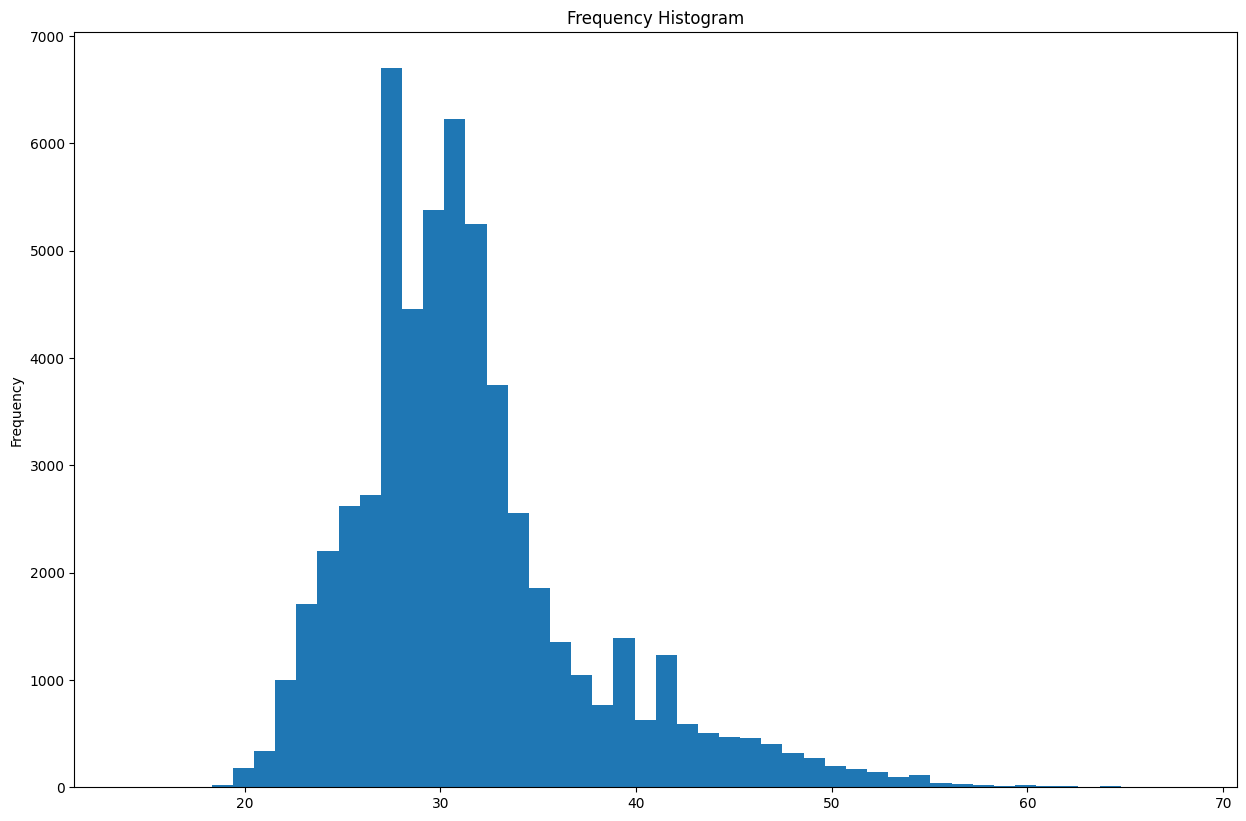

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'figure.figsize':(15,10), 'figure.dpi':100})

a = pd.Series(celeba_annotations_age[:, 1:2].flatten()).astype(int)

# Plot Histogram on x
x = np.random.normal(size = 1000)
plt.hist(a, bins=50)
plt.gca().set(title='Frequency Histogram', ylabel='Frequency');

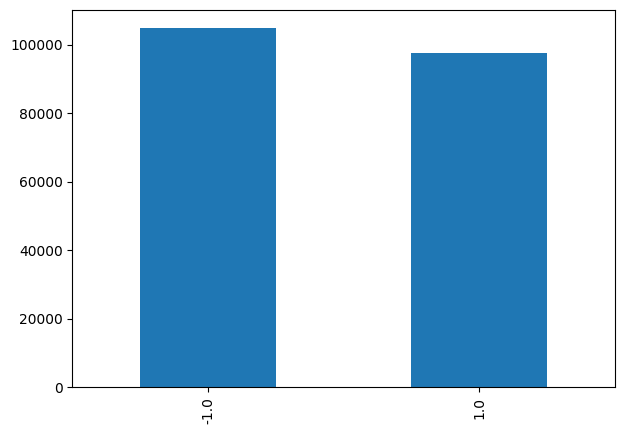

In [ ]:
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})
attr['Smiling'].value_counts().plot(kind='bar')

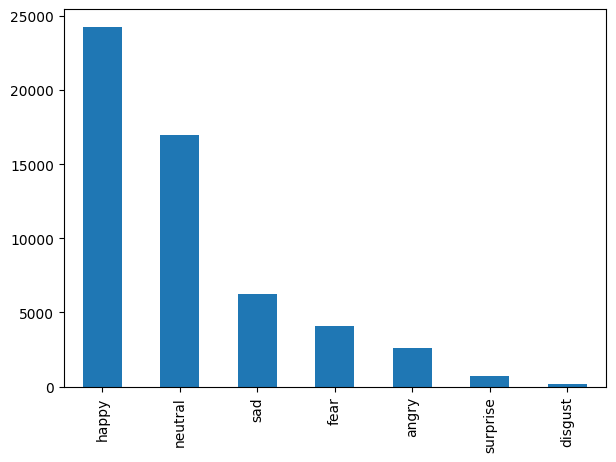

In [ ]:
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})
attr['facial_expression'].value_counts().plot(kind='bar')

In [ ]:
for colnm in attr.columns:
    if colnm != "image_id" and colnm != "facial_expression"  and colnm != "age_predicted":
        print(" {:20} {:5.2f}%".format(
                colnm,100*np.mean(attr[colnm] == 1)))
    elif colnm == "predicted_age":
      print(" {:20} {:5.2f}%".format(
                colnm,100*np.mean(pd.isna(attr[colnm])==False)))
    elif colnm == "facial_expression":
      print(" {:20} {:5.2f}%".format(
                colnm,100*np.mean(pd.isna(attr[colnm])==False)))

 5_o_Clock_Shadow     11.11%
 Arched_Eyebrows      26.70%
 Attractive           51.25%
 Bags_Under_Eyes      20.46%
 Bald                  2.24%
 Bangs                15.16%
 Big_Lips             24.08%
 Big_Nose             23.45%
 Black_Hair           23.93%
 Blond_Hair           14.80%
 Blurry                5.09%
 Brown_Hair           20.52%
 Bushy_Eyebrows       14.22%
 Chubby                5.76%
 Double_Chin           4.67%
 Eyeglasses            6.51%
 Goatee                6.28%
 Gray_Hair             4.19%
 Heavy_Makeup         38.69%
 High_Cheekbones      45.50%
 Male                 41.68%
 Mouth_Slightly_Open  48.34%
 Mustache              4.15%
 Narrow_Eyes          11.51%
 No_Beard             83.49%
 Oval_Face            28.41%
 Pale_Skin             4.29%
 Pointy_Nose          27.74%
 Receding_Hairline     7.98%
 Rosy_Cheeks           6.57%
 Sideburns             5.65%
 Smiling              48.21%
 Straight_Hair        20.84%
 Wavy_Hair            31.96%
 Wearing_Earri

In [ ]:
def plot_image(align,nrow=2, row_value=""):
    figsize = (20,10)
    ncol = 5
    fig = plt.figure(figsize=figsize)
    N = nrow*ncol
    for i, myid in enumerate(align["image_id"][:N]):
        image = load_img(dir_data + "/" + myid)
        image = img_to_array(image)/255.0

        (_, 
         lefteye_x,    lefteye_y,
         righteye_x,   righteye_y, 
         nose_x,       nose_y,
         leftmouth_x,  leftmouth_y, 
         rightmouth_x, rightmouth_y) = align.iloc[i]


        ax  = fig.add_subplot(nrow,ncol,i+1)
        ax.imshow(image)
        #title= str(attr.loc[attr['image_id'] == myid]['image_id'][0])
        
        #print(attr.query(f'image_id == "{myid}"')['facial_expression'])
        ax.set_title(str(attr.query(f'image_id == "{myid}"')['facial_expression']).split("Name")[0][:-1])
        ax.scatter(lefteye_x,    lefteye_y)
        ax.scatter(righteye_x,   righteye_y)
        ax.scatter(nose_x,       nose_y)
        ax.scatter(leftmouth_x,  leftmouth_y)
        ax.scatter(rightmouth_x, rightmouth_y)
#plot_image(align)

facial_expression


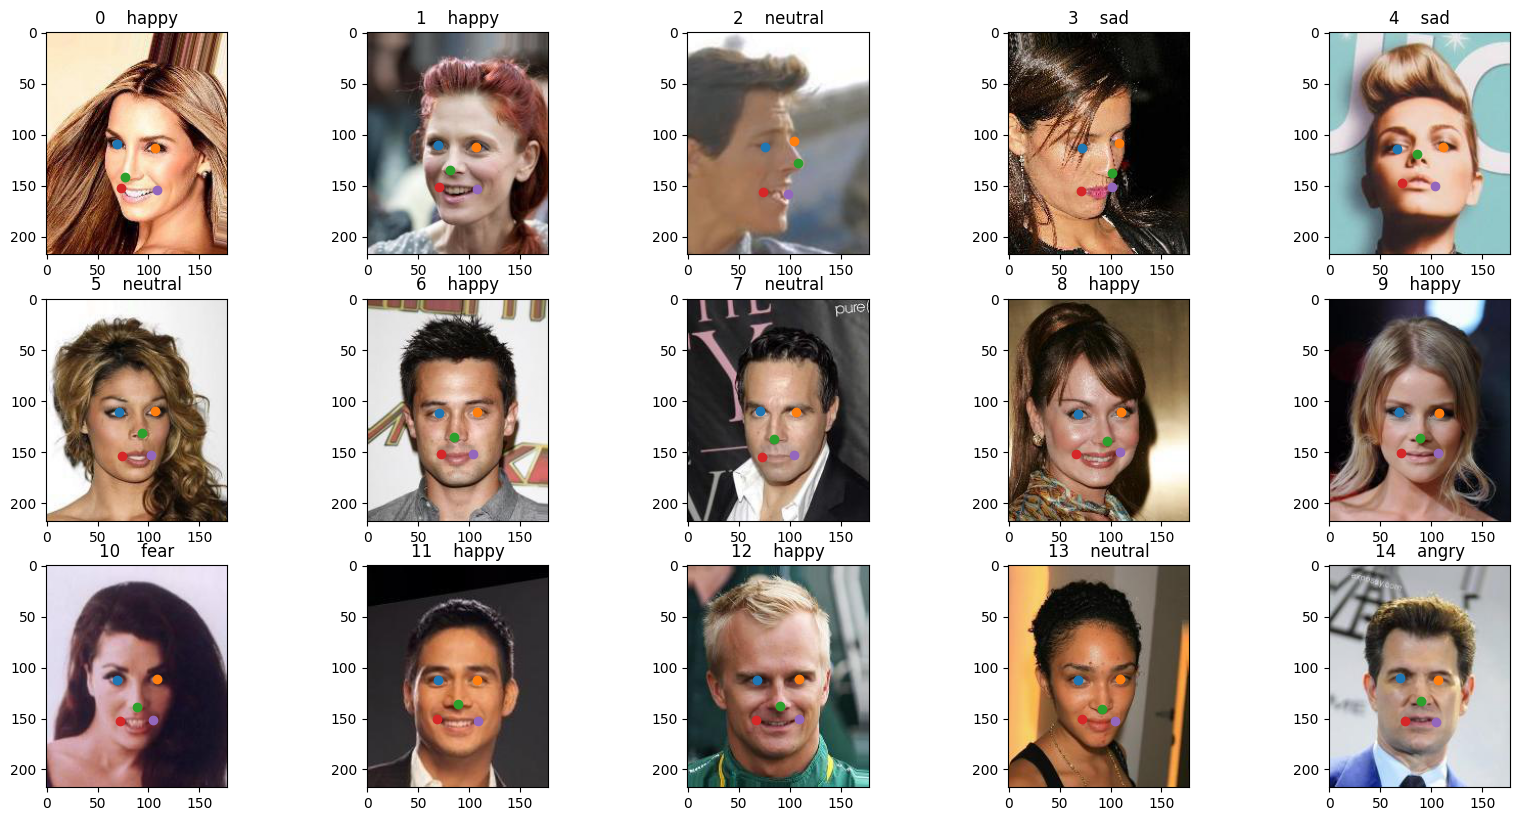

In [ ]:
for attrnm in ["facial_expression"]:
    print(attrnm)
    plot_image(align.loc[pd.isna(attr[attrnm]) == False,:],nrow=3)
    plt.show()

In [ ]:
str(attr.loc[attr['image_id'] == '000002.jpg']['image_id'][0])

'000001.jpg'

In [ ]:
print(attr.query('image_id == "000002.jpg"')['facial_expression'])

1    happy
Name: facial_expression, dtype: object


# Balance dataset

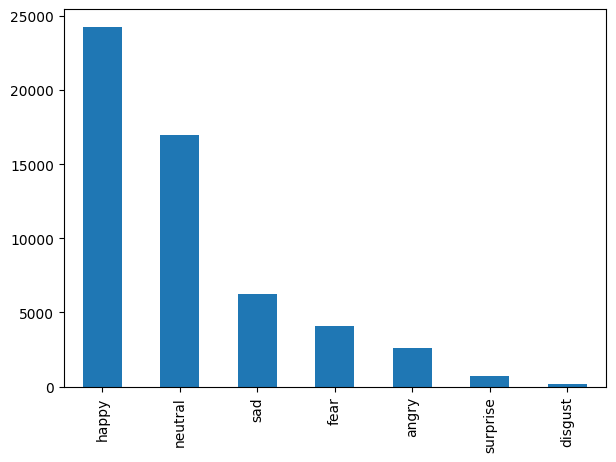

In [ ]:
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})
attr['facial_expression'].value_counts().plot(kind='bar')

In [ ]:
attr_balanced = attr.copy()

In [ ]:
n_samples_with_age = len(attr_balanced[attr_balanced['predicted_age'].notnull()])
n_samples_with_age

57308

In [ ]:
attr_balanced = attr[:n_samples_with_age]

In [ ]:
attr_balanced

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young,facial_expression,predicted_age
0,000001.jpg,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,happy,36
1,000002.jpg,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,happy,32
2,000003.jpg,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,neutral,33
3,000004.jpg,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,-1.0,1.0,sad,30
4,000005.jpg,-1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,sad,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57303,057304.jpg,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,NaN,34
57304,057305.jpg,-1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,NaN,34
57305,057306.jpg,-1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,NaN,30
57306,057307.jpg,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,NaN,30


In [ ]:
n_samples_with_facial_expression = len(attr_balanced[attr_balanced['facial_expression'].notnull()])
n_samples_with_facial_expression


55048

In [ ]:
n_samples_with_facial_expression 

55048

In [ ]:
attr_balanced = attr[:n_samples_with_facial_expression]

In [ ]:
attr_balanced['sad'] = attr_balanced.apply(lambda row: 1.0 if row['facial_expression'] == 'sad' else -1.0, axis=1)

In [ ]:
max_n_samples = attr_balanced['facial_expression'].value_counts()['sad']
max_n_samples

6248

In [ ]:
attr_balanced['Blond_Hair'].value_counts()

-1.0    46929
 1.0     8119
Name: Blond_Hair, dtype: int64

In [ ]:
attr_balanced['Brown_Hair'].value_counts()

-1.0    43879
 1.0    11169
Name: Brown_Hair, dtype: int64

In [ ]:
attr_balanced['Gray_Hair'].value_counts()

-1.0    52763
 1.0     2285
Name: Gray_Hair, dtype: int64

In [ ]:
attr_balanced['Black_Hair'].value_counts()

-1.0    41817
 1.0    13231
Name: Black_Hair, dtype: int64

In [ ]:
#attr_balanced['Gray_Hair'] == 1.0  attr_balanced["facial_expression"] != None

gray_hair = attr_balanced[attr_balanced['Gray_Hair'] == 1.0]
gray_hair

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young,facial_expression,predicted_age
20,000021.jpg,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,happy,31
50,000051.jpg,1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,neutral,46
93,000094.jpg,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,fear,49
124,000125.jpg,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,happy,43
126,000127.jpg,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,happy,43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54994,054995.jpg,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,disgust,46
55002,055003.jpg,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,neutral,61
55011,055012.jpg,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,neutral,46
55030,055031.jpg,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,happy,38


In [ ]:
gray_hair = gray_hair[gray_hair['facial_expression'].notnull()]

In [ ]:
len(gray_hair)

2285